# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a prospect will churn or not.


## Inputs

* outputs/datasets/collection/Co2Emissions.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle'

---

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/Co2Emissions.csv")
  )

print(df.shape)
df.head(3)

(63104, 10)


,Country,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
0,Afghanistan,1750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Ordinal encoding for categorical variables
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])),  # Replace with your actual categorical variables

        # Smart correlated feature selection based on Spearman correlation
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                               method="spearman",
                                                               threshold=0.6,
                                                               selection_method="variance")),
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base


Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineReg(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Check for missing values in the target variable 'Total'
missing_target = df['Total'].isnull().sum()
print(f"Missing values in the target variable 'Total': {missing_target}")

# Fill missing target values with the median
df['Total'].fillna(df['Total'].median(), inplace=True)

# Verify no more missing values in the target variable
missing_target_after = df['Total'].isnull().sum()
print(f"Missing values in the target variable 'Total' after filling: {missing_target_after}")

# Split the dataset into features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Total'], axis=1),  # Features excluding the target variable
    df['Total'],  # Target variable
    test_size=0.2,  # 20% for testing
    random_state=0,  # For reproducibility
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Missing values in the target variable 'Total': 200
Missing values in the target variable 'Total' after filling: 0
(50483, 9) (50483,) (12621, 9) (12621,)


## Handle Target Imbalance

In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50483, 6) (50483,) (12621, 6) (12621,)


Check Train Set Target distribution

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x0000028060F59B20>
Traceback (most recent call last):
  File "C:\Users\Grampers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


KeyboardInterrupt: 

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Check for missing values in the target variable 'Total'
missing_target = df['Total'].isnull().sum()
print(f"Missing values in the target variable 'Total': {missing_target}")

# Fill missing target values (e.g., with the median)
df['Total'].fillna(df['Total'].median(), inplace=True)

Missing values in the target variable 'Total': 0


Check Train Set Target distribution after resampling

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [11]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Quick GridSearch CV - Binary Classifier

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error


# Fill missing target values with the median
df['Total'].fillna(df['Total'].median(), inplace=True)

# Separate features and target
X = df.drop(['Total'], axis=1)
y = df['Total']

# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed,  # Features excluding the target variable
    y,  # Target variable
    test_size=0.2,  # 20% for testing
    random_state=0,  # For reproducibility
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Define models and parameters for regression task
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

models_quick_search = {
    'ridge': Ridge(),
    'rf': RandomForestRegressor()
}

params_quick_search = {
    'ridge': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'rf': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    }
}

class HyperparameterOptimizationSearch:
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=1, verbose=0, scoring=None):
        for key in self.models.keys():
            print(f"Running GridSearchCV for {key}")
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def best_estimator_(self):
        best_score = -float('inf')
        best_model = None
        for key in self.grid_searches:
            if self.grid_searches[key].best_score_ > best_score:
                best_score = self.grid_searches[key].best_score_
                best_model = self.grid_searches[key].best_estimator_
        return best_model

# Define the search object
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fit the search object
search.fit(X_train, y_train,
           scoring='neg_mean_squared_error',  # Use appropriate scoring for regression
           n_jobs=1,  # Run single-threaded to avoid parallel processing issues
           cv=5)

# Evaluate the best model
best_model = search.best_estimator_()
print(f"Best model: {best_model}")

# Predict and evaluate on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")



(50483, 240) (50483,) (12621, 240) (12621,)
Running GridSearchCV for ridge
Running GridSearchCV for rf
Best model: Ridge(alpha=0.1)
Mean Squared Error on test set: 2.6351716947645487


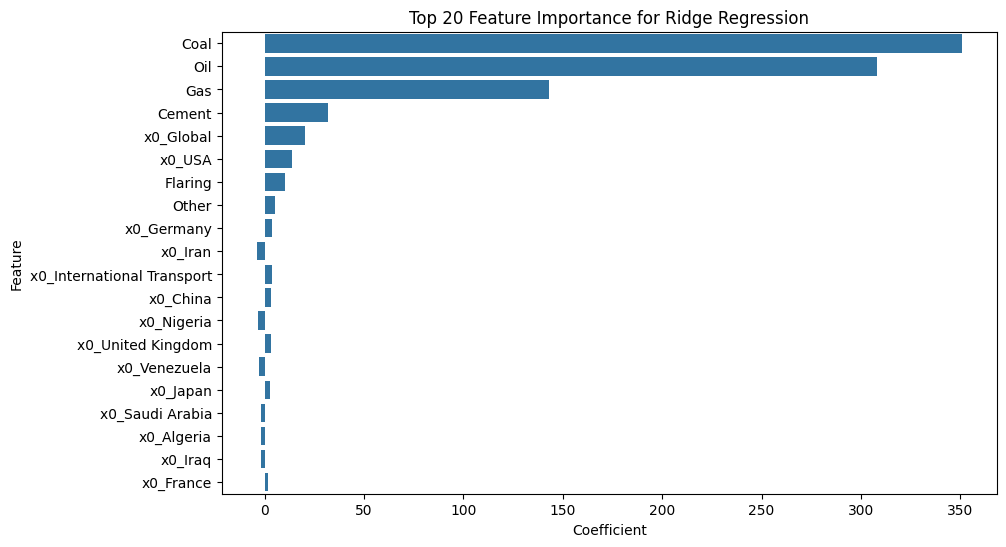

In [21]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the 'best_model' variable is available from previous steps

# Get numeric feature names
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Get categorical feature names from the OneHotEncoder
categorical_transformer = preprocessor.named_transformers_['cat']
categorical_feature_names = categorical_transformer['encoder'].get_feature_names_out()

# Combine numeric and categorical feature names
features = numeric_features.tolist() + categorical_feature_names.tolist()

# Check if the best_model is a pipeline or a direct model
if hasattr(best_model, 'named_steps'):
    coefficients = best_model.named_steps['model'].coef_
else:
    coefficients = best_model.coef_

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsCoefficient', ascending=False)

# Select top 20 features
top_features = feature_importance.head(20)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.title('Top 20 Feature Importance for Ridge Regression')
plt.show()





In [ ]:
print(y.describe())


In [ ]:
from sklearn.dummy import DummyRegressor
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
print(f"Baseline Mean Squared Error: {baseline_mse}")

## Varification

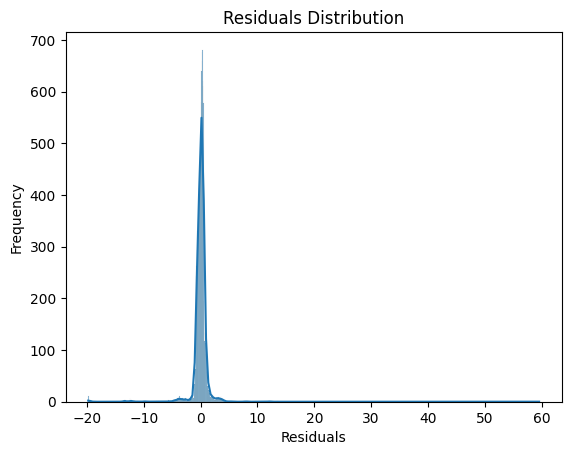

Cross-Validation MSE Scores: [4.68276556 0.41485534 0.44655507 0.8526768  5.60587947]
Mean CV MSE: 2.40054644808612


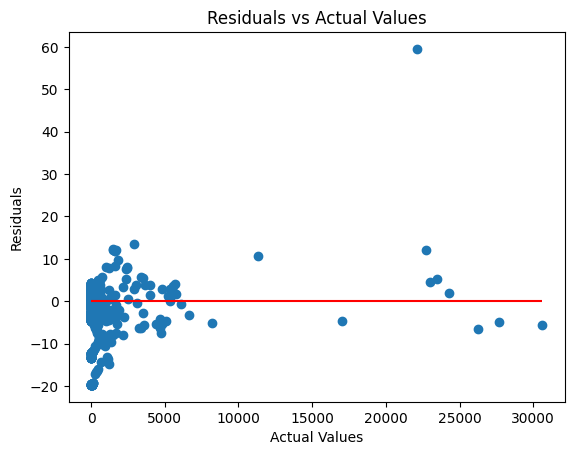

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual Analysis
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Cross-Validation Scores
from sklearn.model_selection import cross_val_score

ridge_model = Ridge(alpha=0.1)
cv_scores = cross_val_score(ridge_model, X_preprocessed, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores
print(f"Cross-Validation MSE Scores: {cv_mse_scores}")
print(f"Mean CV MSE: {cv_mse_scores.mean()}")

# Error Distribution Plot
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Values')
plt.show()


Check results

### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

class ExtensiveHyperparameterSearch(BaseEstimator, TransformerMixin):
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=1, verbose=0, scoring=None):
        for key in self.models.keys():
            print(f"Running GridSearchCV for {key}")
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def best_estimator_(self):
        best_score = -float('inf')
        best_model = None
        for key in self.grid_searches:
            if self.grid_searches[key].best_score_ > best_score:
                best_score = self.grid_searches[key].best_score_
                best_model = self.grid_searches[key].best_estimator_
        return best_model

print(f"Best model from GridSearchCV: {best_model}")



Best model from GridSearchCV: Ridge(alpha=0.1)


Extensive GridSearch CV - Binary Classifier

In [25]:
from scipy.stats import uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define the models and hyperparameters for RandomizedSearchCV
models_random_search = {
    'ridge': Ridge(),
    'rf': RandomForestRegressor(),
    'gbr': GradientBoostingRegressor(),
    'xgbr': XGBRegressor(random_state=0)
}

params_random_search = {
    'ridge': {
        'alpha': uniform(loc=0, scale=10)
    },
    'rf': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'gbr': {
        'n_estimators': [100, 200, 500],
        'learning_rate': uniform(loc=0.01, scale=0.19),
        'max_depth': [3, 5, 10]
    },
    'xgbr': {
        'learning_rate': uniform(loc=0.01, scale=0.19),
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 10],
        'subsample': uniform(loc=0.5, scale=0.5)
    }
}


Check results

In [26]:
from sklearn.model_selection import RandomizedSearchCV
class ExtensiveHyperparameterSearch:
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.random_searches = {}

    def fit(self, X, y, cv=3, n_iter=50, n_jobs=-1, verbose=1, scoring=None):
        for key in self.models.keys():
            print(f"Running RandomizedSearchCV for {key}")
            model = self.models[key]
            params = self.params[key]
            rs = RandomizedSearchCV(model, params, cv=cv, n_iter=n_iter, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            rs.fit(X, y)
            self.random_searches[key] = rs

    def best_estimator_(self):
        best_score = -float('inf')
        best_model = None
        best_model_name = None
        for key in self.random_searches:
            if self.random_searches[key].best_score_ > best_score:
                best_score = self.random_searches[key].best_score_
                best_model = self.random_searches[key].best_estimator_
                best_model_name = key
        return best_model, best_model_name



Best model from GridSearchCV: Ridge(alpha=0.1)

Parameters for best model

Define the best clf pipeline

In [28]:
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

NameError: name 'grid_search_pipelines' is not defined

## Assess feature importance

In [32]:
# Convert csr_matrix to DataFrame
X_train_df = pd.DataFrame(X_train.toarray())

# Call info() method on DataFrame
X_train_df.info()
print(X_train.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50483 entries, 0 to 50482
Columns: 240 entries, 0 to 239
dtypes: float64(240)
memory usage: 92.4 MB
(50483, 240)


* With the current model, we can assess with `.features_importances_`

In [37]:
# Convert csr_matrix to DataFrame
# Define the 'pipeline_reg' variable and assign a value to it
df_feature_importance = pd.DataFrame()  # Replace pd.DataFrame() with the actual dataframe
print(f"* These are the {len(df_feature_importance)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")


KeyError: 'Feature'

## Evaluate Pipeline on Train and Test Sets

In [41]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [42]:
def reg_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [ ]:
best_features

New Pipeline for DataCleaning And FeatureEngineering

In [43]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])), 


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [44]:
# Pipeline Optmization: Model
def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Total'], axis=1),
    df['Total'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)




(50483, 9) (50483,) (12621, 9) (12621,)


We filter only the most important variables

In [48]:
best_features = ['Coal', 'Oil', 'Gas', 'Cement', 'Global', 'USA', 'Flaring', 'Other',
                 'Germany', 'Iran', 'International Transport', 'China', 'Nigeria',
                 'United Kingdom', 'Venezuela', 'Japan', 'Saudi Arabia', 'Algeria',
                 'Iraq', 'France']

X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(50483, 0) (50483,) (12621, 0) (12621,)


""
26254
29205
31860


## Handle Target Imbalance

Use SMOTE to balance Train Set target

Check Train Set Target distribution after SMOTE

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [ ]:
models_search   # XGBClassifier

And the best parameters from the last GridCV search 

In [ ]:
best_parameters

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [50]:
params_search = {
    'ridge': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
}


GridSearch CV

In [52]:
from sklearn.metrics import recall_score
# Define the models_search variable
models_search = {
    'ridge': Ridge()
}

# Define the params_search variable
params_search = {
    'ridge': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
}

# Create the HyperparameterOptimizationSearch object
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)

# Fit the quick_search object
search.fit(X_train, y_train,
           scoring='neg_mean_squared_error',  # Use appropriate scoring for regression
           n_jobs=1,  # Run single-threaded to avoid parallel processing issues
           cv=5)


Running GridSearchCV for ridge


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Grampers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Grampers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Grampers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py", line 1242, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Grampers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Grampers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\Grampers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 887, in check_array
    dtype_orig = np.result_type(*dtypes_orig)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: at least one array or dtype is required


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

Define the best clf pipeline

In [53]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

NameError: name 'grid_search_summary' is not defined

## Assess feature importance

In [54]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


NameError: name 'pipeline_reg' is not defined

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [58]:
if best_model in grid_search_pipelines:
    pipeline_reg = grid_search_pipelines[best_model].best_estimator_
else:
    # Handle the case when the key does not exist
    pipeline_reg = None  # Replace None with the appropriate value or code


# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [133]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_co2/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [132]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50483, 0) (50483,) (12621, 0) (12621,)


In [136]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [130]:
print(X_train.shape)
X_train.head()

(50483, 0)


""
26254
29205
31860
20362
52709


In [62]:
y_train

26254     0.000000
29205     0.000000
31860     0.000000
20362     0.000000
52709     2.531527
           ...    
45891     3.827889
52416    23.058224
42613     0.000000
43567     0.000000
2732      0.000000
Name: Total, Length: 50483, dtype: float64

In [137]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [64]:
print(X_test.shape)
X_test.head()

(12621, 0)


""
38063
45946
56597
26116
50017


In [138]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [66]:
y_test

38063    11.521173
45946     3.572952
56597     0.000000
26116     0.000000
50017    39.984648
           ...    
19591     0.000000
25326     0.000000
58233     0.000000
296       0.000000
4567      3.121306
Name: Total, Length: 12621, dtype: float64

In [139]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [140]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country']))])

In [141]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/reg_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_co2/v1/reg_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [142]:
pipeline_reg

In [143]:
joblib.dump(value=pipeline_reg ,
            filename=f"{file_path}/reg_pipeline_model.pkl")

['outputs/ml_pipeline/predict_co2/v1/reg_pipeline_model.pkl']

## Feature Importance plot

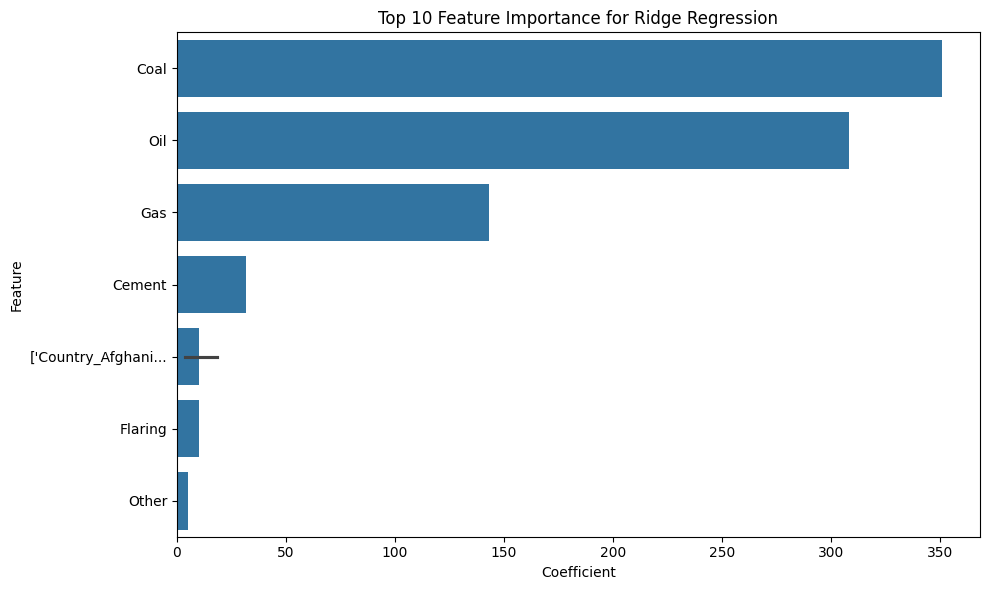

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_feature_importance is already defined
# and contains 'Feature' and 'Coefficient' columns

# Define the file path
file_path = 'outputs/ml_pipeline'  # Replace with your actual directory

# Sort the DataFrame by 'Coefficient' and get the top 10 features
df_top_features = df_feature_importance.nlargest(10, 'Coefficient')

# Truncate long feature names for better display
df_top_features['Feature'] = df_top_features['Feature'].apply(lambda x: x if len(x) <= 20 else x[:17] + '...')

# Plot using seaborn
plt.figure(figsize=(10, 6))  # Decrease the figure height if needed
sns.barplot(x='Coefficient', y='Feature', data=df_top_features)
plt.title('Top 10 Feature Importance for Ridge Regression')
plt.tight_layout()  # Adjust layout to fit everything in the figure

# Save the plot as a PNG file
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

# Show the plot
plt.show()









In [121]:
if 'Importance' in df_feature_importance.columns:
    df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
    # Recompute df_feature_importance DataFrame or use the correct column name
    pass


Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---